In [1]:
"hi"

'hi'

In [2]:
import pandas as pd
url = "https://www.health.state.mn.us/diseases/coronavirus/situation.html#hosp1"

dfs = pd.read_html(url)

In [3]:
for k, df in enumerate(dfs):
    if any(isinstance(c, str) and ("date" in c.lower() or "day" in c.lower()) for c in df.columns):
        print(k, df.columns)

4 Index(['Date reported to MDH',
       'Completed tests reported from the MDH Public Health Lab (daily)',
       'Completed tests reported from external laboratories (daily)',
       'Total approximate number of completed tests'],
      dtype='object')
5 Index(['Specimen collection date', 'Positive cases',
       'Cumulative positive cases'],
      dtype='object')
6 Index(['Date reported', 'Newly reported deaths (daily)', 'Total deaths'], dtype='object')
7 Index(['Date reported', 'Hospitalized in ICU (daily)',
       'Hospitalized, not in ICU (daily)', 'Total hospitalizations',
       'Total ICU hospitalizations'],
      dtype='object')


In [5]:
# Want: deaths, ICU/hosp, new cases

cases = dfs[5]
assert "Positive cases" in cases.columns
assert "Cumulative positive cases" in cases.columns
print(cases.columns)
assert (cases.columns == ['Specimen collection date', 'Positive cases', 'Cumulative positive cases']).all()
cases.columns = ["Date reported", "Positive cases (daily)", "Total positive cases"]

deaths = dfs[6]
assert "Newly reported deaths (daily)" in deaths.columns
assert "Total deaths" in deaths.columns

icu = dfs[7]
print(icu.columns)
assert "Hospitalized in ICU (daily)" in icu.columns
assert "Total ICU hospitalizations" in icu.columns

Index(['Specimen collection date', 'Positive cases',
       'Cumulative positive cases'],
      dtype='object')
Index(['Date reported', 'Hospitalized in ICU (daily)',
       'Hospitalized, not in ICU (daily)', 'Total hospitalizations',
       'Total ICU hospitalizations'],
      dtype='object')


In [6]:
cases

,Date reported,Positive cases (daily),Total positive cases
0,3/5,1,1
1,3/6,0,1
2,3/7,1,2
3,3/8,0,2
4,3/9,3,5
...,...,...,...
110,6/23,532,34786
111,6/24,353,35139
112,6/25,308,35447
113,6/26,101,35548


In [7]:
df = pd.merge(cases, deaths, on="Date reported")
df = pd.merge(df, icu, on="Date reported")

In [8]:
df.to_csv("data/mn.csv", index=False)

In [9]:
df.head()

,Date reported,Positive cases (daily),Total positive cases,Newly reported deaths (daily),Total deaths,Hospitalized in ICU (daily),"Hospitalized, not in ICU (daily)",Total hospitalizations,Total ICU hospitalizations
0,3/21,24,327,1,1,4,2,12,4
1,3/22,22,349,0,1,5,5,12,5
2,3/23,44,393,0,1,5,7,21,5
3,3/24,51,444,0,1,7,8,25,7
4,3/25,58,502,0,1,12,14,35,12


In [10]:
from datetime import datetime, timedelta

def parse_datetime(x):
    month, day = x.split("/")
    return datetime(2020, int(month), int(day))

df["datetime"] = df["Date reported"].apply(parse_datetime)
df.columns

Index(['Date reported', 'Positive cases (daily)', 'Total positive cases',
       'Newly reported deaths (daily)', 'Total deaths',
       'Hospitalized in ICU (daily)', 'Hospitalized, not in ICU (daily)',
       'Total hospitalizations', 'Total ICU hospitalizations', 'datetime'],
      dtype='object')

In [11]:
assert (df.columns == ['Date reported', 'Positive cases (daily)',
       'Total positive cases', 'Newly reported deaths (daily)',
       'Total deaths', 'Hospitalized in ICU (daily)',
       'Hospitalized, not in ICU (daily)', 'Total hospitalizations',
       'Total ICU hospitalizations', "datetime"]).all()

df.columns

Index(['Date reported', 'Positive cases (daily)', 'Total positive cases',
       'Newly reported deaths (daily)', 'Total deaths',
       'Hospitalized in ICU (daily)', 'Hospitalized, not in ICU (daily)',
       'Total hospitalizations', 'Total ICU hospitalizations', 'datetime'],
      dtype='object')

In [12]:
df["in_hosp"] = df["Hospitalized in ICU (daily)"] + df["Hospitalized, not in ICU (daily)"]

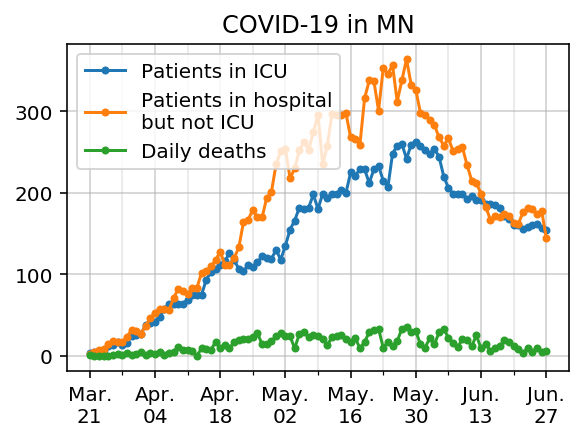

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

w = 3
fig, ax = plt.subplots(figsize=(1.5 * w, w))

style = ".-"
ax.plot(df.datetime, df["Hospitalized in ICU (daily)"], style, label="Patients in ICU")
ax.plot(df.datetime, df["Hospitalized, not in ICU (daily)"], style, label="Patients in hospital\nbut not ICU")
ax.plot(df.datetime, df["Newly reported deaths (daily)"], style, label="Daily deaths")
# ax.plot(df.datetime, df["Change in positive cases (daily)"], label="New positive tests")
ax.legend(loc="best")
# ax.set_yscale("log")
start = df.datetime.min()

weeks = [start + timedelta(k * 14) for k in range(52)]
ax.xaxis.set_major_locator(plt.FixedLocator([mdates.date2num(_) for _ in weeks]))

weeks = [start + timedelta(k * 14 + 7) for k in range(52)]
ax.xaxis.set_minor_locator(plt.FixedLocator([mdates.date2num(_) for _ in weeks]))
ax.grid(which="minor", axis="x", alpha=0.3)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b.\n%d"))
ax.grid(alpha=0.6)
ax.set_title("COVID-19 in MN")
# ax.set_ylabel("Number")
fig.savefig("imgs/mn.png", dpi=300, bbox_inches="tight")
fig.savefig("imgs/mn.svg", bbox_inches="tight")